In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from PIL import Image,ImageFile
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [3]:
from PIL import Image

In [4]:
!python3 -m pip install nltk

  Using cached https://files.pythonhosted.org/packages/73/fb/00a976f728d0d1fecfe898238ce23f502a721c0ac0ecfedb80e0d88c64e9/six-1.12.0-py2.py3-none-any.whl
You are using pip version 19.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [118]:
def read_textFile(path):
    with open(path) as f:
        captions=f.read()
    return captions    

In [119]:
captions=read_textFile("Desktop/Flickr8k.token.txt")

In [8]:
caption=captions.split('\n')[:-1]
print(len(caption))
print(type(caption))
print(type(caption[0]))
print(caption[0].split('\t'))

40460
<class 'list'>
<class 'str'>
['1000268201_693b08cb0e.jpg#0', 'A child in a pink dress is climbing up a set of stairs in an entry way .']


In [9]:
description={}
cnt=0
for x in caption:
    i_to_c=x.split('\t')
    img_name=i_to_c[0].split(".")[0]
    cap=i_to_c[1]
    if description.get(img_name) is None:
        description[img_name]=[]
    description[img_name].append(cap)

In [10]:
description["97406261_5eea044056"]

['A calico cat raising its paws towards a dog with an open mouth',
 'A cat swatting at a doberman dog',
 'A dog and cat are fighting on a chair .',
 'A multicolor cat fighting with a black and brown dog in a red collar .',
 'The yellow and black cat and the brown and black dog are fighting .']

(-0.5, 499.5, 428.5, -0.5)

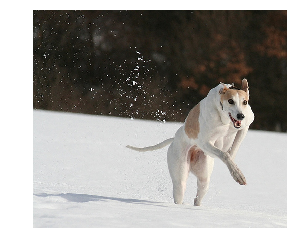

In [11]:
IMG_PATH="Flicker8k_Dataset/101654506_8eb26cfb60.jpg"
import cv2
import matplotlib.pyplot as plt
img=cv2.imread(IMG_PATH)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")

In [12]:
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence

In [13]:
clean_text("I like to play tennis")

'like to play tennis'

In [14]:
for key,caption_list in description.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])
        

In [15]:
with open("description1.txt","w") as f:
    f.write(str(description))

In [16]:
descriptions=None
with open("description1.txt","r") as f:
    descriptions=f.read()
    
json_acceptable_string=descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_string)

In [17]:
print(type(descriptions))
print(descriptions)

<class 'dict'>
{'929679367_ff8c7df2ee': ['beagle is playing with tennis ball', 'puppy dog is playing with tennis ball', 'puppy is playing with tennis ball on well kept path lined with groomed bushes', 'puppy plays with tennis ball on stone path', 'white footed beagle plays with tennis ball on garden path'], '2765029348_667111fc30': ['bikers flips upside down', 'man does flip trick on his bicycle', 'man is doing back flip off ramp on mountain bike in the wild', 'man is doing back flip whilst attempting jump on bicycle', 'man performs back flip on his bmx bicycle'], '241347803_afb04b12c4': ['football player is in red and white uniform sooners', 'large football player in red uniform', 'man in red football uniform and helmet looks to the left', 'the oklahoma football player watches the game from the sidelines', 'this football team wears red shirts and red helmets'], '3634032601_2236676cdd': ['crowd of people with lady with bright orange shirt and another lady in black have their backs to t

In [18]:
#unique words
vocab=set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in description[key]]
print(len(vocab))    

8424


In [19]:
total_words=[]
for key in description.keys():
    [total_words.append(i) for des in description[key] for i in des.split()]
print(len(total_words))    

373837


In [20]:
import collections
counter=collections.Counter(total_words)
print(type(counter))
freq_cnt=dict(counter)
print(freq_cnt)

<class 'collections.Counter'>
{'completely': 4, 'typical': 1, 'local': 4, 'curl': 2, 'grayhound': 2, 'deflated': 7, 'artificial': 10, 'sunbathe': 3, 'emblazoned': 1, 'workers': 18, 'headdresses': 2, 'vibrant': 1, 'present': 3, 'rain': 51, 'average': 1, 'fiels': 1, 'contracption': 1, 'buoy': 2, 'passenager': 1, 'blocks': 26, 'flatbed': 1, 'spotting': 1, 'stickball': 1, 'groceries': 3, 'puddles': 4, 'hug': 28, 'vegetation': 4, 'action': 24, 'draw': 3, 'bike': 868, 'hindu': 1, 'wood': 73, 'chains': 5, 'peer': 2, 'jubilant': 1, 'hair': 414, 'wedgie': 1, 'pauses': 10, 'ban': 1, 'needs': 1, 'put': 26, 'countryside': 14, 'sequins': 2, 'which': 51, 'downpour': 1, 'classmates': 1, 'fashioned': 8, 'footballers': 6, 'boots': 66, 'cliffside': 3, 'burns': 1, 'childern': 1, 'laborador': 1, 'ballet': 9, 'fell': 5, 'meandering': 2, 'crash': 7, 'wigs': 4, 'holding': 1324, 'hurdles': 11, 'crossing': 58, 'outfit': 159, 'softball': 53, 'piled': 4, 'slowly': 1, 'utilities': 1, 'parody': 1, 'climbed': 4, 's

In [21]:
sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
threshold=10
print(type(sorted_freq_cnt))
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_cnt]
print(len(total_words))

<class 'list'>
1845


In [23]:
train_file_data=read_textFile('Desktop/Flickr_8k.trainImages.txt')

In [24]:
test_file_data=read_textFile('Desktop/Flickr_8k.testImages.txt')

In [25]:
print(type(train_file_data))

<class 'str'>


In [26]:
train_description={}
train_image_ids=[img_id.split('.')[0] for img_id in train_file_data.split('\n')[:-1]]
print(len(train_image_ids))

6000


In [27]:
test_description={}
test_image_ids=[img_id.split('.')[0] for img_id in test_file_data.split('\n')[:-1]]

In [29]:
cnt=0
train_img_id1=set()
for img_id in train_image_ids:
    train_description[img_id]=[]
    for cap in descriptions[img_id]:
        cnt+=1
        train_img_id1.update([img_id])
        print(cnt)
        cap_to_append="startseq"+cap+"endseq"
        train_description[img_id].append(cap_to_append)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216


5995
5996
5997
5998
5999
6000
6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
6042
6043
6044
6045
6046
6047
6048
6049
6050
6051
6052
6053
6054
6055
6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066
6067
6068
6069
6070
6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081
6082
6083
6084
6085
6086
6087
6088
6089
6090
6091
6092
6093
6094
6095
6096
6097
6098
6099
6100
6101
6102
6103
6104
6105
6106
6107
6108
6109
6110
6111
6112
6113
6114
6115
6116
6117
6118
6119
6120
6121
6122
6123
6124
6125
6126
6127
6128
6129
6130
6131
6132
6133
6134
6135
6136
6137
6138
6139
6140
6141
6142
6143
6144
6145
6146
6147
6148
6149
6150
6151
6152
6153
6154
6155
6156
6157
6158
6159
6160
6161
6162
6163
6164
6165
6166
6167
6168
6169
6170
6171
6172
6173
6174
6175
6176
6177
6178
6179
6180
6181
6182
6183
6184
6185
6186
6187
6188
6189
6190
6191
6192
6193
6194


9016
9017
9018
9019
9020
9021
9022
9023
9024
9025
9026
9027
9028
9029
9030
9031
9032
9033
9034
9035
9036
9037
9038
9039
9040
9041
9042
9043
9044
9045
9046
9047
9048
9049
9050
9051
9052
9053
9054
9055
9056
9057
9058
9059
9060
9061
9062
9063
9064
9065
9066
9067
9068
9069
9070
9071
9072
9073
9074
9075
9076
9077
9078
9079
9080
9081
9082
9083
9084
9085
9086
9087
9088
9089
9090
9091
9092
9093
9094
9095
9096
9097
9098
9099
9100
9101
9102
9103
9104
9105
9106
9107
9108
9109
9110
9111
9112
9113
9114
9115
9116
9117
9118
9119
9120
9121
9122
9123
9124
9125
9126
9127
9128
9129
9130
9131
9132
9133
9134
9135
9136
9137
9138
9139
9140
9141
9142
9143
9144
9145
9146
9147
9148
9149
9150
9151
9152
9153
9154
9155
9156
9157
9158
9159
9160
9161
9162
9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173
9174
9175
9176
9177
9178
9179
9180
9181
9182
9183
9184
9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198
9199
9200
9201
9202
9203
9204
9205
9206
9207
9208
9209
9210
9211
9212
9213
9214
9215


12515
12516
12517
12518
12519
12520
12521
12522
12523
12524
12525
12526
12527
12528
12529
12530
12531
12532
12533
12534
12535
12536
12537
12538
12539
12540
12541
12542
12543
12544
12545
12546
12547
12548
12549
12550
12551
12552
12553
12554
12555
12556
12557
12558
12559
12560
12561
12562
12563
12564
12565
12566
12567
12568
12569
12570
12571
12572
12573
12574
12575
12576
12577
12578
12579
12580
12581
12582
12583
12584
12585
12586
12587
12588
12589
12590
12591
12592
12593
12594
12595
12596
12597
12598
12599
12600
12601
12602
12603
12604
12605
12606
12607
12608
12609
12610
12611
12612
12613
12614
12615
12616
12617
12618
12619
12620
12621
12622
12623
12624
12625
12626
12627
12628
12629
12630
12631
12632
12633
12634
12635
12636
12637
12638
12639
12640
12641
12642
12643
12644
12645
12646
12647
12648
12649
12650
12651
12652
12653
12654
12655
12656
12657
12658
12659
12660
12661
12662
12663
12664
12665
12666
12667
12668
12669
12670
12671
12672
12673
12674
12675
12676
12677
12678
12679
12680
1268

16015
16016
16017
16018
16019
16020
16021
16022
16023
16024
16025
16026
16027
16028
16029
16030
16031
16032
16033
16034
16035
16036
16037
16038
16039
16040
16041
16042
16043
16044
16045
16046
16047
16048
16049
16050
16051
16052
16053
16054
16055
16056
16057
16058
16059
16060
16061
16062
16063
16064
16065
16066
16067
16068
16069
16070
16071
16072
16073
16074
16075
16076
16077
16078
16079
16080
16081
16082
16083
16084
16085
16086
16087
16088
16089
16090
16091
16092
16093
16094
16095
16096
16097
16098
16099
16100
16101
16102
16103
16104
16105
16106
16107
16108
16109
16110
16111
16112
16113
16114
16115
16116
16117
16118
16119
16120
16121
16122
16123
16124
16125
16126
16127
16128
16129
16130
16131
16132
16133
16134
16135
16136
16137
16138
16139
16140
16141
16142
16143
16144
16145
16146
16147
16148
16149
16150
16151
16152
16153
16154
16155
16156
16157
16158
16159
16160
16161
16162
16163
16164
16165
16166
16167
16168
16169
16170
16171
16172
16173
16174
16175
16176
16177
16178
16179
16180
1618

19514
19515
19516
19517
19518
19519
19520
19521
19522
19523
19524
19525
19526
19527
19528
19529
19530
19531
19532
19533
19534
19535
19536
19537
19538
19539
19540
19541
19542
19543
19544
19545
19546
19547
19548
19549
19550
19551
19552
19553
19554
19555
19556
19557
19558
19559
19560
19561
19562
19563
19564
19565
19566
19567
19568
19569
19570
19571
19572
19573
19574
19575
19576
19577
19578
19579
19580
19581
19582
19583
19584
19585
19586
19587
19588
19589
19590
19591
19592
19593
19594
19595
19596
19597
19598
19599
19600
19601
19602
19603
19604
19605
19606
19607
19608
19609
19610
19611
19612
19613
19614
19615
19616
19617
19618
19619
19620
19621
19622
19623
19624
19625
19626
19627
19628
19629
19630
19631
19632
19633
19634
19635
19636
19637
19638
19639
19640
19641
19642
19643
19644
19645
19646
19647
19648
19649
19650
19651
19652
19653
19654
19655
19656
19657
19658
19659
19660
19661
19662
19663
19664
19665
19666
19667
19668
19669
19670
19671
19672
19673
19674
19675
19676
19677
19678
19679
1968

23014
23015
23016
23017
23018
23019
23020
23021
23022
23023
23024
23025
23026
23027
23028
23029
23030
23031
23032
23033
23034
23035
23036
23037
23038
23039
23040
23041
23042
23043
23044
23045
23046
23047
23048
23049
23050
23051
23052
23053
23054
23055
23056
23057
23058
23059
23060
23061
23062
23063
23064
23065
23066
23067
23068
23069
23070
23071
23072
23073
23074
23075
23076
23077
23078
23079
23080
23081
23082
23083
23084
23085
23086
23087
23088
23089
23090
23091
23092
23093
23094
23095
23096
23097
23098
23099
23100
23101
23102
23103
23104
23105
23106
23107
23108
23109
23110
23111
23112
23113
23114
23115
23116
23117
23118
23119
23120
23121
23122
23123
23124
23125
23126
23127
23128
23129
23130
23131
23132
23133
23134
23135
23136
23137
23138
23139
23140
23141
23142
23143
23144
23145
23146
23147
23148
23149
23150
23151
23152
23153
23154
23155
23156
23157
23158
23159
23160
23161
23162
23163
23164
23165
23166
23167
23168
23169
23170
23171
23172
23173
23174
23175
23176
23177
23178
23179
2318

26513
26514
26515
26516
26517
26518
26519
26520
26521
26522
26523
26524
26525
26526
26527
26528
26529
26530
26531
26532
26533
26534
26535
26536
26537
26538
26539
26540
26541
26542
26543
26544
26545
26546
26547
26548
26549
26550
26551
26552
26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
2667

In [30]:
train_img_id_final=list(train_img_id1)
print(len(train_img_id_final))

6000


In [31]:
test_img_id1=set()
cnt=0
for img_id in test_image_ids:
    cnt+=1
    test_description[img_id]=[]
    for cap in descriptions[img_id]:
        test_img_id1.update([img_id])
        cap_to_append="startseq"+cap+"endseq"
        test_description[img_id].append(cap_to_append)
print(cnt)        

1000


In [32]:
test_img_id_final=list(test_img_id1)
print(len(test_img_id_final))                       

1000


In [33]:
print(train_description)

{'2765029348_667111fc30': ['startseqbikers flips upside downendseq', 'startseqman does flip trick on his bicycleendseq', 'startseqman is doing back flip off ramp on mountain bike in the wildendseq', 'startseqman is doing back flip whilst attempting jump on bicycleendseq', 'startseqman performs back flip on his bmx bicycleendseq'], '3634032601_2236676cdd': ['startseqcrowd of people with lady with bright orange shirt and another lady in black have their backs to the cameraendseq', 'startseqlarge group of people doing varied activitiesendseq', 'startseqwoman in black tank top and man in an orange shirt sit their backs to the cameraendseq', 'startseqthe back view of woman in colorful shirt sitting next to woman in black topendseq', 'startseqtwo women with backs to the cameraendseq'], '3258391809_38fc6211f7': ['startseqman and woman adjust camera on tripod outdoorsendseq', 'startseqman and woman setup cameraendseq', 'startseqpair work with the cameraendseq', 'startseqthe man and the woman w

In [34]:
print(test_description)

{'1682079482_9a72fa57fa': ['startseqlittle girl on kid swingendseq', 'startseqlittle girl shouts for joy as she swings on the swingendseq', 'startseqtoddler girl in swing is laughingendseq', 'startseqtoddler in pink shirt in bucket swingendseq', 'startseqyoung girl making wide mouthed expression while swingingendseq'], '929679367_ff8c7df2ee': ['startseqbeagle is playing with tennis ballendseq', 'startseqpuppy dog is playing with tennis ballendseq', 'startseqpuppy is playing with tennis ball on well kept path lined with groomed bushesendseq', 'startseqpuppy plays with tennis ball on stone pathendseq', 'startseqwhite footed beagle plays with tennis ball on garden pathendseq'], '3503689049_63212220be': ['startseqan african american in sunglasses and white tee shirt smilesendseq', 'startseqyoung black man in sunglasses is smiling broadlyendseq', 'startseqyoung man wearing dark sunglasses smilingendseq', 'startseqsmiling bald black man in sunglasses and shirtendseq', 'startseqthe smiling bl

In [35]:
model=ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()








__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
act

In [36]:
model_new=Model(model.input,model.layers[-2].output)

In [37]:
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    #reshaping the image
    img=np.expand_dims(img,axis=0)
    #Normalisation
    img=preprocess_input(img)
    return img
img=preprocess_img("Flicker8k_Dataset/101654506_8eb26cfb60.jpg")    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


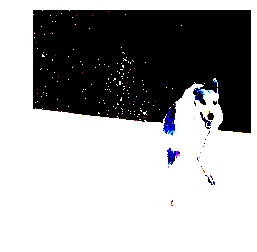

In [38]:

plt.imshow(img[0])
plt.axis("off")
plt.show()

In [39]:
def Encode_img(img):
    img1=preprocess_img(img)
    feature_vector=model_new.predict(img1)
    feature_vector=feature_vector.reshape((1,2048))
    return feature_vector

In [46]:
start=time()
encoding_train={}
for ix,img_id in enumerate(train_img_id_final):
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    img_path='Flicker8k_Dataset'+"/"+img_id+".jpg"
    encoding_train[img_id]=Encode_img(img_path)
    
    if ix%100==0:
        print(ix)
end_t=time()
print(end_t-start)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
952.2662312984467


In [47]:
print(len(encoding_train))

6000


In [48]:
start=time()
encoding_test={}
for ix,image_id in enumerate(test_img_id_final):
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    img_path='Flicker8k_Dataset'+"/"+image_id+".jpg"
    encoding_test[image_id]=Encode_img(img_path)
end_t=time()    
print(end_t-start)


180.0269913673401


In [49]:
print(len(encoding_test))

1000


In [50]:
with open("encoded_train_features1.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [51]:
pickle_in = open("encoded_train_features1.pkl","rb")
y=pickle.load(pickle_in)
print(y)

{'2765029348_667111fc30': array([[0.258359  , 0.01486558, 0.03258748, ..., 1.6125635 , 0.        ,
        0.3459981 ]], dtype=float32), '3634032601_2236676cdd': array([[0.07929939, 1.5855342 , 0.10272627, ..., 0.04877246, 2.5118148 ,
        0.        ]], dtype=float32), '3258391809_38fc6211f7': array([[0.15883698, 2.4397185 , 0.11895433, ..., 0.3188538 , 0.52737737,
        0.5479403 ]], dtype=float32), '3036641436_d6594fc45f': array([[0.17643884, 0.17698538, 0.        , ..., 0.0292883 , 0.8198403 ,
        0.02736904]], dtype=float32), '2903469015_a1e7d969c2': array([[0.01513502, 0.06349001, 0.2865401 , ..., 0.1931102 , 0.49449688,
        0.        ]], dtype=float32), '664470170_6a1ad20c45': array([[0.17932133, 0.78047925, 0.3051178 , ..., 0.370688  , 0.44287932,
        0.61590034]], dtype=float32), '3223606402_bb2aa6db95': array([[0.3367767 , 0.49264696, 0.05397236, ..., 0.07572884, 0.32326424,
        0.10095587]], dtype=float32), '1859726819_9a793b3b44': array([[0.6594879 , 1.0

In [52]:
with open("encoded_test_features1.pkl","wb") as f:
    pickle.dump(encoding_test,f)
    

In [53]:
pickle_out=open("encoded_test_features1.pkl","rb")
Y_test=pickle.load(pickle_out)
print(Y_test)

{'1682079482_9a72fa57fa': array([[0.37315303, 0.15453508, 0.09003293, ..., 0.1284479 , 1.0708601 ,
        0.06257296]], dtype=float32), '929679367_ff8c7df2ee': array([[0.1771981 , 0.19105053, 0.21555825, ..., 0.484384  , 0.37372142,
        0.54052734]], dtype=float32), '2884301336_dc8e974431': array([[1.2273899 , 0.27750954, 0.26943228, ..., 0.7702317 , 0.26704356,
        0.14634992]], dtype=float32), '2683963310_20dcd5e566': array([[0.01080689, 0.        , 0.5437066 , ..., 0.        , 0.49839938,
        0.4487345 ]], dtype=float32), '2883099128_0b056eed9e': array([[0.24554144, 0.54942924, 0.00190978, ..., 0.35094842, 0.01173798,
        0.03552205]], dtype=float32), '2676764246_c58205a365': array([[0.7629981 , 0.781753  , 0.45830035, ..., 0.53495073, 1.1832075 ,
        0.43175152]], dtype=float32), '2763044275_aa498eb88b': array([[0.3796898 , 3.608483  , 0.79142   , ..., 2.4573526 , 0.21214217,
        0.05707634]], dtype=float32), '2435685480_a79d42e564': array([[0.05674692, 0.9

In [77]:
word_to_idx={}
idx_to_word={}
for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word
    

In [78]:
idx_to_word[1847]='startseq'
word_to_idx['startseq']=1847
idx_to_word[1848]='endseq'
word_to_idx['endseq']=1848

In [80]:
vocab_size=len(word_to_idx)+1
print(vocab_size)

1848


In [81]:
max_len=0
for key in train_description.keys():
    for cap in train_description[key]:
        max_len=max(max_len,len(cap.split()))
print(max_len)        

33


In [82]:
def data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size):
    x1,x2,y=[],[],[]
    n=0
    while True:
        for key,desc_list in train_description.items():
            
            n+=1
            photo=encoding_train[key+".jpg"]
            for desc in desc_list:
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]
                    
                    xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi=to_categorical([yi],num_classes=vocab_size)[0]
                    
                    
                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)
                    if n==batch_size :
                        yield[[np.array(x1),np.array(x2)],np.array(y)]
                        x1,x2,y=[],[],[]
                        n=0
            

In [83]:

embedding_index={}
f=open("glove.6B.50d.txt")
for line in f:
    values=line.split()
    word=values[0]
    word_embedding=np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding
f.close()
    

In [84]:
def get_embeddingMatrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
    return matrix        

In [85]:
embedding_matrix=get_embeddingMatrix()
print(embedding_matrix.shape)

(1848, 50)


In [87]:
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)

In [88]:
input_captions=Input(shape=(max_len,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

In [89]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='relu')(decoder2)


#cobining two models
model=Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [90]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 33, 50)       92400       input_6[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           input_5[0][0]                    
__________________________________________________________________________________________________
dropout_5 

In [112]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [113]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [114]:
epochs=10
batch_size=3
steps = len(train_description)//batch_size

In [121]:
for i in range(epochs):
    try:
        generator=data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1, steps_per_epoch=steps, verbose=1)
        model.save('./model_weights/model_' + str(i) + '.h5')
    except:
        pass

Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1
Epoch 1/1


In [ ]:
model.predict()